In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

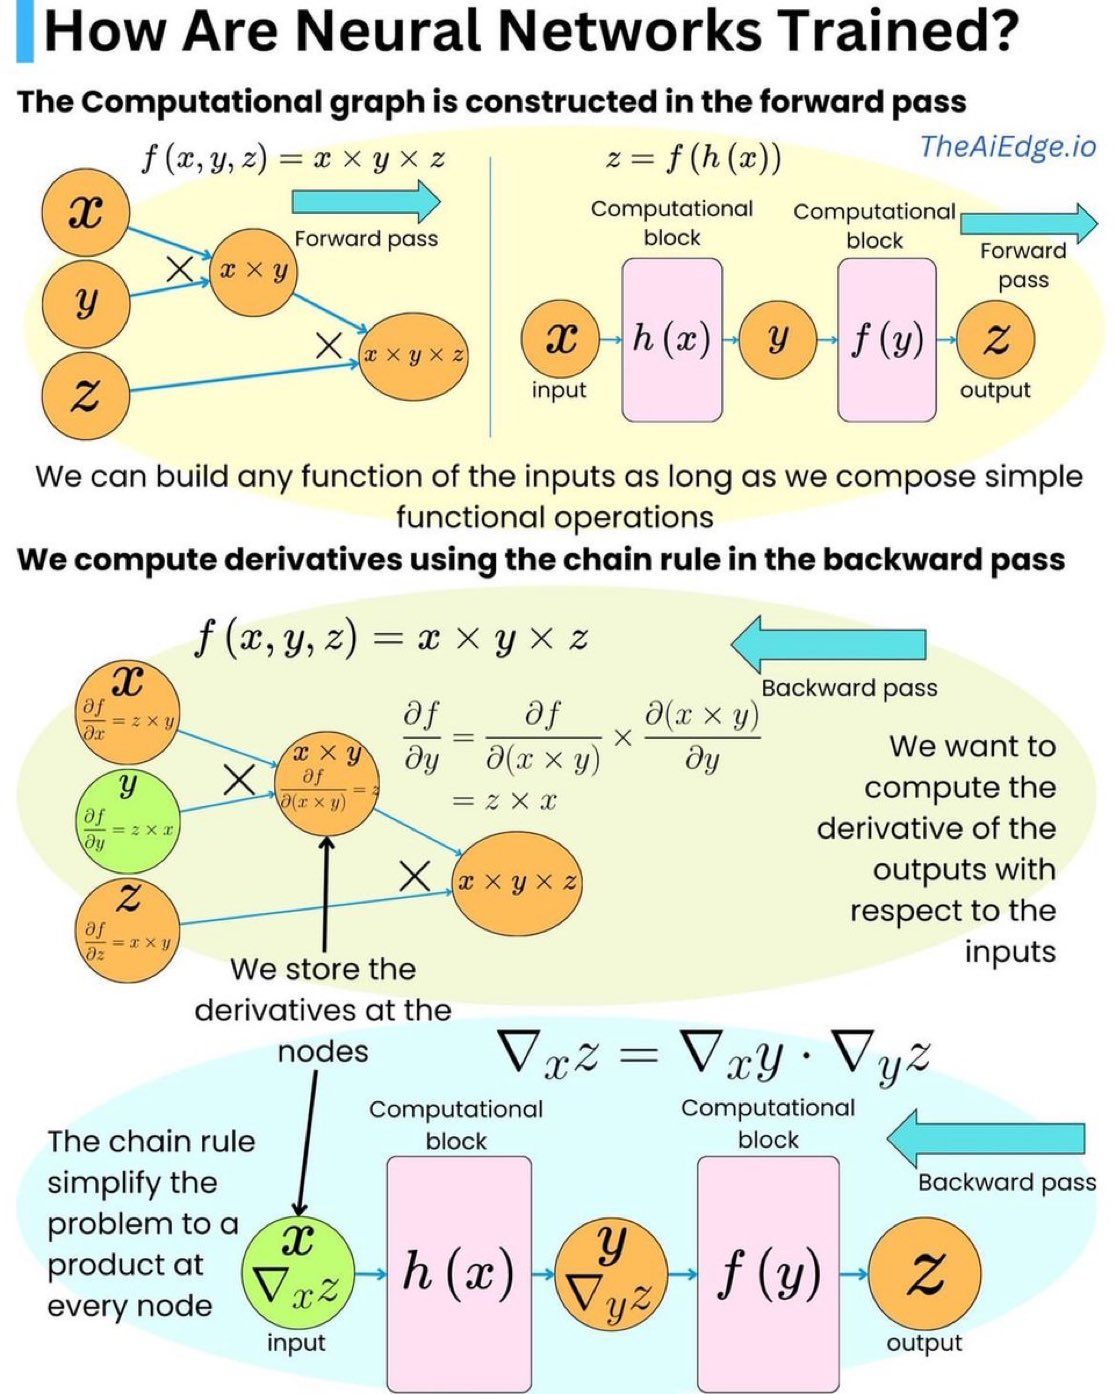

### Backpropagation from scratch

### Generalized Error Backpropagaition for Any layer

$$\Large\delta^{[l]}=\frac{\partial L}{\partial Z^{[l]}}=\frac{\partial L}{\partial A^{[l]}}\odot \frac{\partial A}{\partial Z^{[l]}}=\delta^{l+1}W^{[l+1]} \odot \sigma'(z^{[l]})$$

**gradient parameter**
$$\Large\frac{\partial L}{\partial W^{[l]}}=\delta^{[l]T}A^{[l-1]}$$
$$\Large\frac{\partial L}{\partial b^{[l]}}=\sum{\delta^{[l]}}$$

In [46]:
def linear_backward(A, W, b, z):
    W.grad_ = z.grad_.T @ A
    b.grad_ = torch.sum(z.grad_, dim=0)
    A.grad_ = z.grad_ @ W

def relu_backward(z, A):
    z.grad_ = A.grad_ * (z>0).float()

In [47]:
def softmax_cross_entropy(x, y_true):

    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    softmax_output = e_x / torch.sum(e_x, dim=-1,keepdim=True) + 1e-10
    loss = -torch.sum(y_true * torch.log(softmax_output+ 1e-10)) / y_true.shape[0]

    return loss, softmax_output

In [48]:
def linear(X, W, b):
    return X@W.T + b

def relu(Z):
    return Z.clamp_min(0.)
def forward_backward(X, y):
    # forward
    Z1 = linear(X,W1,b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    loss, A2 = softmax_cross_entropy(Z2,y)

    # backward
    Z2.grad_ = (A2 - y) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)

    return loss, Z1, A1, Z2, A2

### Compare results with Autograd

In [180]:
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(images,target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1437, 8, 8) (1437,)
(360, 8, 8) (360,)


In [181]:
# preprocessing data
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1,64)
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)

X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1,64)
y_val = F.one_hot(torch.tensor(y_val), num_classes=10)

#normalization
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

In [172]:
m, n = X_train.shape

nh= 30 # number of hidden layer neurons
class_num = 10
# W1 = torch.randn((nh, n), requires_grad=True) # output x input
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1,nh), requires_grad=True) # 1 x nh

# W2 = torch.rand((class_num, nh), requires_grad=True)
W2 = torch.randn((class_num,nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1,class_num), requires_grad=True)
loss, Z1, A1, Z2, A2 = forward_backward(X_train, y_train)

# autograd
loss.backward()

In [76]:
Z2.grad == Z2.grad_

tensor([[False,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True, False, False,  ..., False, False, False],
        ...,
        [False,  True,  True,  ..., False,  True,  True],
        [False,  True, False,  ..., False, False,  True],
        [ True, False,  True,  ...,  True,  True,  True]])

Not all of gradients have the same value. This is due to large values in Z2. Inputing such large values into a softmax function returns unstable values.

In [66]:
Z2

tensor([[6.6815e-01, 1.9412e-01, 4.6190e-01,  ..., 6.7576e-02, 3.4622e-02,
         4.0804e-01],
        [4.6283e-01, 3.8033e-01, 1.6008e+00,  ..., 1.2597e+00, 1.8649e+00,
         1.6783e+00],
        [4.6138e+01, 3.4990e+01, 3.2816e+01,  ..., 4.1303e+01, 3.8437e+01,
         4.4803e+01],
        ...,
        [5.2852e+01, 3.9986e+01, 3.6280e+01,  ..., 4.5761e+01, 4.2238e+01,
         5.1130e+01],
        [1.9658e+01, 1.6038e+01, 1.2339e+01,  ..., 1.6186e+01, 1.5451e+01,
         2.2926e+01],
        [1.9925e+00, 1.0710e+00, 1.1298e+00,  ..., 1.7635e+00, 1.5072e+00,
         2.8835e+00]], grad_fn=<AddBackward0>)

In [67]:
X_train

tensor([[-0.8119, -0.8119, -0.3139,  ...,  1.3459, -0.1479, -0.8119],
        [-0.8119, -0.8119,  0.6820,  ..., -0.3139, -0.8119, -0.8119],
        [-0.8119, -0.8119, -0.8119,  ...,  0.1840, -0.8119, -0.8119],
        ...,
        [-0.8119, -0.8119,  0.6820,  ...,  1.8439, -0.4799, -0.8119],
        [-0.8119, -0.8119, -0.6459,  ..., -0.8119, -0.8119, -0.8119],
        [-0.8119, -0.8119, -0.6459,  ..., -0.6459, -0.8119, -0.8119]])

In [69]:
Z1

tensor([[-1.2345, -3.5868, -3.8859,  ...,  0.6438, -3.0002, -2.8253],
        [-3.7590, -0.9433, -3.6602,  ..., -1.2557, -2.1354, -3.8087],
        [ 0.7664,  4.8794,  1.5471,  ...,  2.7545,  2.0620, -0.2536],
        ...,
        [ 3.3619,  6.3161,  1.6896,  ...,  3.6176,  0.7358,  2.4133],
        [-0.1012,  5.5298, -1.2030,  ..., -0.4551, -3.1179, -1.3277],
        [-3.0476, -1.6174, -3.3693,  ..., -3.1016, -3.8619, -1.7228]],
       grad_fn=<AddBackward0>)

X_train is normalized to avoid having such large values. Z1 still looks ok. However, since $Z2 = Z1 * W2 + b$, Z2 significantlly grows as you increase layers. This is one of issues in NN. <br>
<br>
W1 is taken from a normal distribution ($W1 \sim N(0,1)$) of mean=0, std=1<br> 
Instead, taking an initial parameter from this normal distribution $W1 \sim N(0,2/n)$ avoids this issue.

```python
# W1 = torch.randn((nh, n), requires_grad=True) # output x input
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
```

In [77]:
W1.grad

tensor([[-0.0458, -0.0440, -0.0186,  ...,  0.0508,  0.0143, -0.0304],
        [-0.0105, -0.0105, -0.0082,  ...,  0.0070, -0.0071, -0.0095],
        [-0.0308, -0.0316, -0.0142,  ..., -0.0055, -0.0214, -0.0326],
        ...,
        [-0.0306, -0.0224,  0.0397,  ...,  0.0210,  0.0082, -0.0238],
        [ 0.0119,  0.0094, -0.0090,  ..., -0.0175, -0.0016,  0.0023],
        [ 0.0109,  0.0103, -0.0031,  ...,  0.0042,  0.0102,  0.0105]])

In [78]:
W1.grad_

tensor([[-0.0458, -0.0440, -0.0186,  ...,  0.0508,  0.0143, -0.0304],
        [-0.0105, -0.0105, -0.0082,  ...,  0.0070, -0.0071, -0.0095],
        [-0.0308, -0.0316, -0.0142,  ..., -0.0055, -0.0214, -0.0326],
        ...,
        [-0.0306, -0.0224,  0.0397,  ...,  0.0210,  0.0082, -0.0238],
        [ 0.0119,  0.0094, -0.0090,  ..., -0.0175, -0.0016,  0.0023],
        [ 0.0109,  0.0103, -0.0031,  ...,  0.0042,  0.0102,  0.0105]],
       grad_fn=<MmBackward0>)

#### check if gradient from scratch is similar to gradients from autograd

In [80]:
print(f'W1: {torch.allclose(W1.grad, W1.grad_)}')
print(f'b1: {torch.allclose(b1.grad, b1.grad_)}')
print(f'W2: {torch.allclose(W2.grad, W2.grad_)}')
print(f'b2: {torch.allclose(b2.grad, b2.grad_)}')

W1: True
b1: True
W2: True
b2: True


### Integrate backpropagation with MLP

Using a learning loop developed during multiclass logistic regression model in multiclass_Logistic_Regression.ipynb,
integragte a MLP model and backpropagation.

In [108]:
epochs = 30
batch_size = 30
num_batches = np.ceil(len(y_train)/batch_size).astype(int)
loss_log = []
learning_rate = 0.03

# logs
train_losses = []
val_losses = []
val_accuracies = []

# initiallize parameters
m, n = X_train.shape

nh= 30 # number of hidden layer neurons
class_num = 10

W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1,nh), requires_grad=True) # 1 x nh

W2 = torch.randn((class_num,nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1,class_num), requires_grad=True)

for epoch in range(epochs):

    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0

    for i in range(num_batches):

        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]

        # place break point
        # import pdb; pdb.set_trace()

        y_true = y_train[batch_indices,:] # data_num x class_num.
        X_train_ = X_train[batch_indices,:] # data_num x feature_num

        # forward
        Z1 = linear(X_train_,W1,b1)
        Z1.retain_grad()
        A1 = relu(Z1)
        A1.retain_grad()
        Z2 = linear(A1, W2, b2)
        Z2.retain_grad()
        loss, A2 = softmax_cross_entropy(Z2,y_true)

        loss_log.append(loss.item())
        running_loss += loss.item()

        # backward
        Z2.grad_ = (A2 - y_true) / X_train_.shape[0]
        linear_backward(A1, W2, b2, Z2)
        relu_backward(Z1, A1)
        linear_backward(X_train_, W1, b1, Z1)

        # update parameter
        with torch.no_grad():
            W1 -= learning_rate * W1.grad_
            b1 -= learning_rate * b1.grad_
            W2 -= learning_rate * W2.grad_
            b2 -= learning_rate * b2.grad_

        # initialize gradient
        W1.grad_ = None
        b1.grad_ = None
        W2.grad_ = None
        b2.grad_ = None

    # validation
    with torch.no_grad():

        Z1_val = linear(X_val,W1,b1)
        A1_val = relu(Z1_val)
        Z2_val = linear(A1_val, W2, b2)

        val_loss, A2 = softmax_cross_entropy(Z2_val, y_val)
        val_accuracy = (torch.sum(torch.argmax(A2, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0])

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    #print log
    print(f'epoch: {epoch+1}: train loss :{running_loss/num_batches:.4f} val loss: {val_loss:.4f} val accuracy {val_accuracy:.4f}')

epoch: 1: train loss :2.0919 val loss: 1.3614 val accuracy 0.6028
epoch: 2: train loss :1.0869 val loss: 0.8210 val accuracy 0.8306
epoch: 3: train loss :0.6866 val loss: 0.5577 val accuracy 0.8750
epoch: 4: train loss :0.4985 val loss: 0.4216 val accuracy 0.8944
epoch: 5: train loss :0.3954 val loss: 0.3439 val accuracy 0.9111
epoch: 6: train loss :0.3288 val loss: 0.2883 val accuracy 0.9306
epoch: 7: train loss :0.2841 val loss: 0.2550 val accuracy 0.9278
epoch: 8: train loss :0.2501 val loss: 0.2286 val accuracy 0.9472
epoch: 9: train loss :0.2249 val loss: 0.2057 val accuracy 0.9472
epoch: 10: train loss :0.2050 val loss: 0.1890 val accuracy 0.9528
epoch: 11: train loss :0.1880 val loss: 0.1758 val accuracy 0.9500
epoch: 12: train loss :0.1739 val loss: 0.1657 val accuracy 0.9556
epoch: 13: train loss :0.1621 val loss: 0.1578 val accuracy 0.9528
epoch: 14: train loss :0.1515 val loss: 0.1471 val accuracy 0.9583
epoch: 15: train loss :0.1417 val loss: 0.1437 val accuracy 0.9639
epoc

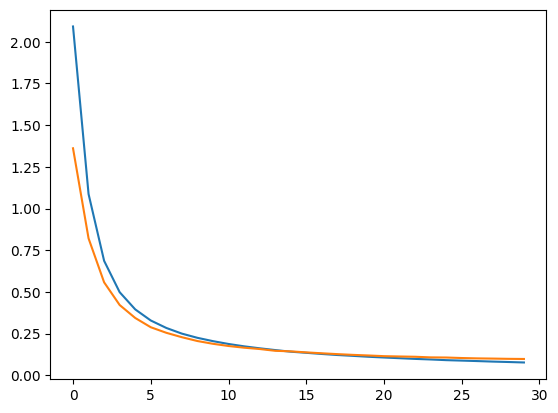

In [109]:
plt.plot(train_losses)
plt.plot(val_losses)

### Regression model

In the preveious section, the model is created for solving a classification problem. In this section, modify the model for a regression prediction. 

Demonstration purpose:
* use mnist dataset
* predict a class number


In [193]:
def mse(X, y):
    return ((X[:,0] - y)**2).mean()

def forward_backward(X, y):
    # forward
    Z1 = linear(X,W1,b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    print(Z2.shape)
    loss = mse(Z2, y)

    # backward
    Z2.grad_ = 2* (Z2 - y.unsqueeze(dim=-1)) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)

    return loss, Z1, A1, Z2

In [194]:
y_train_reg = torch.argmax(y_train,dim=-1)

y_train_reg.shape

# initialize parameter
m, n = X_train.shape

nh= 30 # number of hidden layer neurons
W1 = torch.randn((nh, n), requires_grad=True)
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh

W2 = torch.randn((1,nh), requires_grad=True)
b2 = torch.zeros((1,1), requires_grad=True)

loss, Z1, A1, Z2 = forward_backward(X_train, y_train_reg)
loss.backward()

print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

torch.Size([1437, 1])
True
True
True
True


### Refactoring

In [208]:
class Linear():
    def __init__(self, in_features, out_features):
        self.W = torch.randn((out_features, in_features)*torch.sqrt(torch.tensor(2.0/in_featires)))
        self.W.requires_grad = True
        self.b = torch.zeros((1, out_features), requires_grad=True)

    def forward(X):
        self.X = X
        self.Z = X@W.T + b
        return self.Z

    def backward(self, Z):
        self.W.grad_ = Z.grad_.T @ self.X
        self.b.grad_ = torch.sum(Z.grad_, dim=0)
        self.X.grad_ = Z.grad_
        return self.X.grad_

class Relu():
    def forward(self,X):
        self.X = X
        return X.clamp_min(0.)

    def backward(self,A):
        return A.grad_ * (self.X > 0).float()

class SoftmaxCrossEntropy():
    def forward(self, X, y):
        e_x = torch.exp(X - torch.max(X, dim=-1, keepdim=True)[0])
        self.softmax_output = e_x / torch.sum(e_x, dim=-1,keepdim=True) + 1e-10

        log_probs = torch.log(self.softmax_output + 1e-10)
        target_log_probs = y * log_probs

        self.loss = -target_log_probs.sum(dim=1).mean()

        return self.loss

    def backward(self, y):
        return (self.softmaxt_out - y)/ y.shape[0]


class Model():
    def __init__(self, input_features, hidden_units, output_units):
        self.linear1 = Linear(input_features, hidden_units)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_units, output_units)
        self.loss_fn = SoftmaxCrossEntropy()

    def forward(self,X,y):
        self.X = X
        self.Z = self.linear1.forward(X)
        self.A1 = self.relu.forward(self.Z)
        self.Z2 = self.linear2.forward(self.A1)

        self.loss = self.loss_fn.forward(Z2, y)
        return self.loss, self.Z2

    def backward(self, y):

        self.Z2.grad_ = self.loss_fn.backward(y)
        self.A1.grad_ = self.linear2.backward(self.Z2)
        self.Z1.grad_ = self.relu.backward(self.A1)
        self.X.grad_ = self.linear1.backward(self.Z1)

    def zero_grad(self):
        # initialize grad
        self.linear1.W.grad_ = None
        self.linear1.b.grad_ = None
        self.linear2.W.grad_ = None
        self.linear2.b.grad_ = None

    def step(self, learning_rate):
        # update grad
        self.linear1.W -=  learning_rate * self.linear1.W.grad_
        self.linear1.b -=  learning_rate * self.linear1.b.grad_
        self.linear2.W -=  learning_rate * self.linear1.W.grad_
        self.linear2.b -=  learning_rate * self.linear2.b.grad_